# Fig 3: SWOT in the Mawar Typhoon
##### A.B Villas Bôas, G.Marechal, A Bohé

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import BoundaryNorm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import cmocean
import sys

sys.path.insert(0, '../src')
from src import *

In [2]:
path_out = '../figures/'  # path, where to save the figure?
file_out = 'Fig03_TC.png' # figure name?

ds_SWOT### TC

In [3]:
date_SWOT = np.datetime64('2023-05-27T06:00')
lon_min, lon_max, lat_min, lat_max = 123, 140, 10, 26

#######################################################################################################################################
# ------------------------------------------------------ SWOT ------------------------------------------------------------------------
#######################################################################################################################################

ds_SWOT = xr.open_dataset('../data/SWOT/SWOT_TC.nc')
ds_SWOT_HS = xr.open_dataset('../data/SWOT/SWOT_TC_HS.nc')


#######################################################################################################################################
# ------------------------------------------------------ MODEL ------------------------------------------------------------------------
#######################################################################################################################################

ds_ww3 = xr.open_dataset('../data/WW3/WW3_TC_HYCOM_outputs.nc')
ds_ww3_nocur = xr.open_dataset('../data/WW3/WW3_TC_CTRL_outputs.nc')

#######################################################################################################################################
# ------------------------------------------------------ SWIM ------------------------------------------------------------------------
#######################################################################################################################################

ds_SWIM_ribbons = xr.open_dataset('../data/SWIM_offnadir/spec_TC_SWIM_L2S.nc')
ds_SWIM_alti = xr.open_dataset('../data/SWIM_alti/alti_TC_SWIM.nc')


#######################################################################################################################################
# ------------------------------------------------------ Sentinel ------------------------------------------------------------------------
#######################################################################################################################################
ds_sat = xr.open_dataset('../data/sentinel/sentinel_image.nc')
ds_sat_pos = xr.open_dataset('../data/sentinel/sentinel_lonlat.nc')


#######################################################################################################################################
# ------------------------------------------------------ Best Track ------------------------------------------------------------------------
#######################################################################################################################################
df = pd.read_csv('../data/Mawar_typhon2.csv')
day_Mawar = df['Day']
hour_Mawar = df['Hour']

latitude_Mawar = df['Lat.']
longitude_Mawar = df['Long.']
wind_Mawar = df['Wind (kt)']
pressure_Mawar = df['Pressure (hPa)']
id_27May = np.where(day_Mawar == 27)[0]
id_6oclock = np.where(hour_Mawar[id_27May] == 6)[0][0]

kt2ms = 0.514444 # factor to switch from knot to m/sec


In [4]:
mission = 'TC'
###########
# --- Prepare axis and variables to plot
###########

wind_speed = (ds_ww3_nocur.uwnd**2 + ds_ww3_nocur.vwnd**2)**(1/2) # Wind Speed
current_speed = (ds_ww3.ucur**2 + ds_ww3.vcur**2)**(1/2) # Current Speed Model
u_speed_swot = (ds_SWOT.geo_zonal_current**2 + ds_SWOT.geo_meridional_current**2)**(1/2) # Current Speed SWOT

LON_HYCOM, LAT_HYCOM = np.meshgrid(ds_ww3.longitude.values, ds_ww3.latitude.values)

# ---  Arrows for current direction -> Model
n_quiver = 1
ugos_masked = np.ma.masked_where(current_speed<1, ds_ww3.ucur.values.squeeze()) # masking arrow
vgos_masked = np.ma.masked_where(current_speed<1, ds_ww3.vcur.values.squeeze()) # masking arrow


In [5]:
theta_SWIM = ds_SWIM_ribbons.phi_geo[:].values * np.pi/180 
wavenumber_SWIM = ds_SWIM_ribbons.k.values
spec_SWIM = (ds_SWIM_ribbons.wave_spectra[:, :]*(ds_SWIM_ribbons.k.values)**(-1)).values.T

# Compute Bulk
print(f'The Bulk from SWIM are:')
print(f'________________________')
print('\n')
theta_swim, sub_k, e_kth, Lp, Dp, the_mp, sigp, Qp, Qkk = compute_bulk_l2s_SWIM(ds_SWIM_ribbons, 15) # Compute Bulk and wave spectrum from SWIM



The Bulk from SWIM are:
________________________


Qkk = 59.487415805048386 m
Peak Wavelength = 410.04114210352003 m
Peak Direction = 114.4196704855121 deg


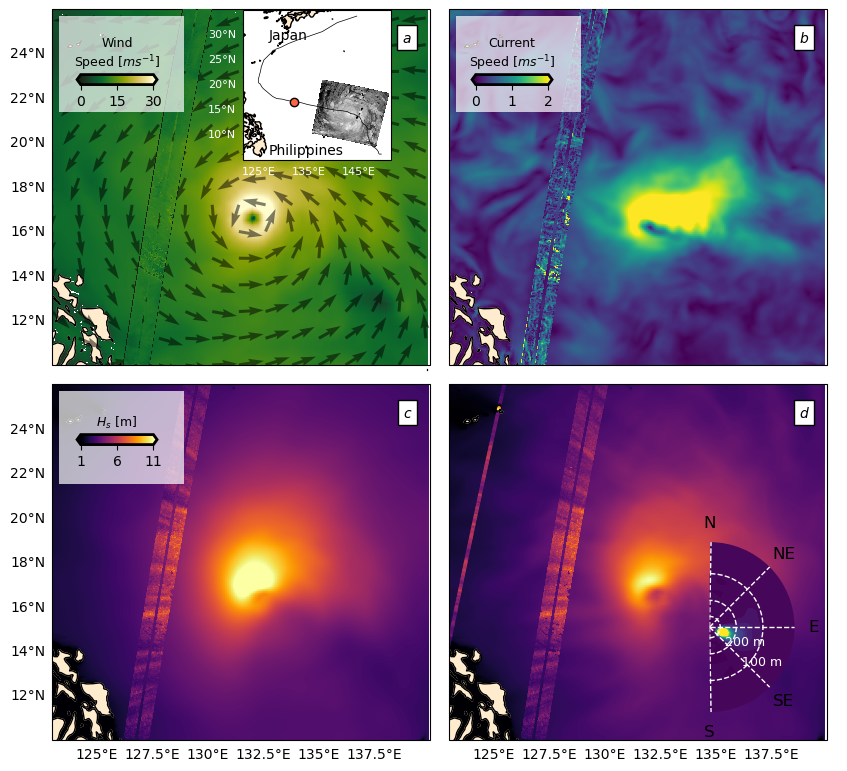

In [6]:
#######################################################################################################################################
# ------------------------------------------------------ Wind Speed -------------------------------------------------------------------
#######################################################################################################################################

vmin = 0
vmax = 60
n_quiver = 40
nb_track = 4
fig = plt.figure(figsize = (10, 10))
lon_min, lon_max, lat_min, lat_max = 123, 140, 10, 26
##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree()) 
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# --- Create the feature
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)


# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels = True
gl.bottom_labels = False
gl.top_labels = False


# --- Plots
# bounds = np.r_[np.linspace(5, 10, 100), np.linspace(10, , 110), np.linspace(35, 60, 40)]  # non continuous colormap
# norm = BoundaryNorm(bounds, 256)
# ax.scatter(ds_jason.longitude, ds_jason.latitude, c = ds_jason.VAVH, s = 5,  norm = norm, cmap = 'inferno')


p1 = ax.pcolormesh(ds_ww3.longitude, ds_ww3.latitude, wind_speed, vmin = 0, vmax = 30, cmap =  cmocean.cm.speed_r)
ax.pcolormesh(ds_SWOT.longitude, ds_SWOT.latitude, ds_SWOT.wind_speed, vmin = 0, vmax = 30, cmap = cmocean.cm.speed_r, zorder = 4)
ax.quiver(ds_ww3.longitude[::n_quiver], ds_ww3.latitude[::n_quiver], ds_ww3.uwnd[::n_quiver,::n_quiver]/wind_speed[::n_quiver,::n_quiver], ds_ww3.vwnd[::n_quiver,::n_quiver]/wind_speed[::n_quiver,::n_quiver],\
         scale = 15, width = 0.008, alpha = .5, zorder = 3)

# s2 = ax.scatter(longitude_Mawar[::nb_track], latitude_Mawar[::nb_track], c=wind_Mawar[::nb_track] * kt2ms, edgecolor = 'k', linewidth = .5, vmin = 10, vmax = 60, cmap = cmocean.cm.speed_r, alpha = .7)
# ax.scatter(longitude_Mawar[30], latitude_Mawar[30],  c=wind_Mawar[30] * kt2ms, s=wind_Mawar[30] * 1.5 * kt2ms, linewidth = 1, alpha = 1, edgecolor = 'r', vmin = 10, vmax = 60, cmap = cmocean.cm.speed_r)


ax.text(.95, .9, 'a', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})


# --- Colorbar settings
cbbox = inset_axes(ax, '33%', '27%', loc = 2)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

cax = fig.add_axes([.15, .785, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [0, 15, 30])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('Wind\nSpeed [$ms^{-1}$]', fontsize = 9)
cbar.ax.minorticks_off()  # Disable minor ticks

ax_inset = fig.add_axes([.315, .71, 0.15, .15], projection=ccrs.PlateCarree())


lon_min, lon_max, lat_min, lat_max = 122, 151.5, 5, 35

ax_inset.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


#s2 = ax_inset.scatter(longitude_Mawar, latitude_Mawar, c=wind_Mawar * kt2ms, edgecolor = 'k', linewidth = .5, vmin = 10, vmax = 60, cmap = cmocean.cm.speed_r)
#ax_inset.scatter(longitude_Mawar[30], latitude_Mawar[30],  c=wind_Mawar[30] * kt2ms, s=wind_Mawar[30] * 1.5 * kt2ms, linewidth = 1, alpha = 1, edgecolor = 'r', vmin = 10, vmax = 60, cmap = cmocean.cm.speed_r)
ax_inset.contourf(ds_sat_pos.longitude_bn, ds_sat_pos.latitude_bn, ds_sat.S6_radiance_bn, np.linspace(0, 9, 30), cmap = 'binary_r')


# s2 = ax_inset.scatter(longitude_Mawar[::nb_track], latitude_Mawar[::nb_track], c=wind_Mawar[::nb_track] * kt2ms, s = 12, edgecolor = 'k', linewidth = .5, norm = norm, cmap = cmocean.cm.speed_r, alpha = .7)
# ax_inset.scatter(longitude_Mawar[30], latitude_Mawar[30],  c=wind_Mawar[30] * kt2ms, s=wind_Mawar[30] * 1.5 * kt2ms, linewidth = 1, alpha = 1, edgecolor = 'r', norm = norm, cmap = cmocean.cm.speed_r)
ax_inset.plot(longitude_Mawar, latitude_Mawar, color = 'k', linewidth = .5)
ax_inset.plot(longitude_Mawar[30], latitude_Mawar[30],  wind_Mawar[30] * kt2ms, marker = 'o', color = 'tomato', markeredgecolor = 'k')

ax_inset.text(127, 29., 'Japan')
ax_inset.text(127, 6, 'Philippines')

#ax_inset.stock_img()

gl = ax_inset.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.right_labels =False
gl.left_labels = True
gl.bottom_labels = True
gl.top_labels =False
gl.xlabel_style = {'size': 8, 'color': 'w','rotation':0}
gl.ylabel_style = {'size': 8, 'color': 'w','rotation':0}
#here
ax_inset.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax_inset.add_feature(cfeature.COASTLINE, zorder = 4)

# cax = fig.add_axes([.68, .53, 0.02, 0.25])
# cbar2 = plt.colorbar(s2, cax = cax, extend = 'both', orientation = 'vertical', ticks = [10, 35, 60])
# cbar2.ax.set_ylabel('[m/sec]')


#######################################################################################################################################
# ------------------------------------------------------ Current Speed -------------------------------------------------------------------
#######################################################################################################################################
lon_min, lon_max, lat_min, lat_max = 123, 140, 10, 26
# --- Vmin and Vmax
vmin = 0
vmax = 2
n_quiver = 12 # number of quivers

##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree()) 
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# Create the feature
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)


# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels =False
gl.bottom_labels =False
gl.top_labels =False

# --- Plots
p1 = ax.pcolor(ds_ww3.longitude, ds_ww3.latitude, current_speed, vmin = vmin, vmax = vmax, cmap = 'viridis')
# ax.quiver(LON_HYCOM[::n_quiver, ::n_quiver], LAT_HYCOM[::n_quiver, ::n_quiver], ugos_masked[::n_quiver, ::n_quiver]/current_speed[::n_quiver, ::n_quiver], vgos_masked[::n_quiver, ::n_quiver]/current_speed[::n_quiver, ::n_quiver], scale = 30, width = 0.005, facecolor = 'w', edgecolor = 'k', linewidth = .8)
ax.pcolor(ds_SWOT.longitude, ds_SWOT.latitude, u_speed_swot, vmin = vmin, vmax = vmax, cmap = 'viridis', zorder = 3)


ax.text(.95, .9, 'b', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})


# --- Colorbar settings

cbbox = inset_axes(ax, '33%', '27%', loc = 2)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

cax = fig.add_axes([.545, .785, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('Current\nSpeed [$ms^{-1}$]', fontsize = 9)


#######################################################################################################################################
# --------------------------------------------- Significant Wave Height (CTRL) ------------------------------------------------------
#######################################################################################################################################

vmin = 1
vmax = 11

##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)


# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)

# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels = True
gl.bottom_labels = True
gl.top_labels =False

# --- Plots
p1 = ax.pcolor(ds_ww3_nocur.longitude, ds_ww3_nocur.latitude, ds_ww3_nocur.hs, vmin = vmin, vmax = vmax, cmap = 'inferno')
ax.contourf(ds_SWOT_HS.reference_longitude, ds_SWOT_HS.reference_latitude, ds_SWOT_HS['swh_2Dmap_2.0km'], np.linspace(vmin, vmax, 100), cmap = 'inferno')


ax.text(.95, .9, 'c', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})



# --- Colorbar settings

cbbox = inset_axes(ax, '33%', '26%', loc = 2)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


# cax = fig.add_axes([.155, .75, 0.17, 0.02])
cax = fig.add_axes([.15, .425, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('$H_{s}$ [m]', fontsize = 9)

#######################################################################################################################################
# --------------------------------------------- Significant Wave Height (HYCOM) ------------------------------------------------------
#######################################################################################################################################

vmin = 1
vmax = 11

##########
# --- Cartopy axes
##########
ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# --- Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)


# --- Activate and deactivate labels

gl.right_labels =False
gl.left_labels =False
gl.bottom_labels = True
gl.top_labels =False

# --- Plots
p1 = ax.pcolor(ds_ww3.longitude, ds_ww3.latitude, ds_ww3.hs, vmin = vmin, vmax = vmax, cmap = 'inferno')
ax.contourf(ds_SWOT_HS.reference_longitude, ds_SWOT_HS.reference_latitude, ds_SWOT_HS['swh_2Dmap_2.0km'], np.linspace(vmin, vmax, 100), cmap = 'inferno')
plt.scatter(ds_SWIM_alti.longitude.values-360, ds_SWIM_alti.latitude.values, c = ds_SWIM_alti.swh.values, s = 3, vmin= vmin, vmax = vmax, cmap = plt.cm.inferno)



# --- Colorbar settings

cax_cbar = fig.add_axes([.5, .5, 0.0001, 0.0001])
cax_cbar.set_xticks([])
cax_cbar.set_yticks([])
#ax.set_title('No Ref.')

ax.text(.95, .9, 'd', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})

# --- SWIM Spectrum
vmin0 = 0
vmax0 = 120
side_spec = 'right'


# fig, ax = plt.subplots(subplot_kw = {'projection':'polar'})
plt.subplots_adjust(wspace=.05, hspace=-.05)

ax_inset = fig.add_axes([.74, .12, 0.17, .245], projection='polar')
# cax_cbar = fig.add_axes([.25, .1, .1, .01]) # position of the colorbar for spec. (decomment and comment it for the final version)
plot_polar_spec_SWIM(ax_inset, cax_cbar, theta_SWIM, wavenumber_SWIM, spec_SWIM, vmin0, vmax0, side_spec, path_out, file_out)